In [1]:
#data analysis
import pandas as pd
import numpy as np

#visualization
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

#python packages
from datetime import date
import os
import warnings

In [2]:
#visualization parameters
sns.set_style("dark")
rcParams['figure.figsize'] = 15,7
warnings.filterwarnings("ignore")

# The JPX stock dataset
First let's perform some basic exploratory data analysis 

### Import data

In [3]:
data = pd.read_csv("../../train_files/stock_prices.csv")
specs = pd.read_csv("../../data_specifications/stock_price_spec.csv")
stock_list = pd.read_csv("../../stock_list.csv")
#give the column securities code a shorter name
data.rename(columns = {'SecuritiesCode':'Code'}, inplace=True)

#### What does our data look like? 
Our data is tabular with each row containing an
1. ID
2. Date
3. Code (corresponding to a stock)
4. Features for each date
    - Opening Price
    - Max Price
    - Min Price
    - Closing Price
    - Volume sold
5. A feature called 'AdjustmentFactor'
    - Indicates whether a stock split/reverse-split occurs
6. A feature called 'ExpectedDividend'
    - If a stock pays dividend, what is the expected dividend
7. A feature called 'SupervisionFlag'
    - Whether or not a stock is under supervision or about to be delisted
8. The target column 
    - % daily return for a stock bought one day in the future and sold a day later

In [4]:
data.head()

,RowId,Date,Code,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324
2,20170104_1333,2017-01-04,1333,3150.0,3210.0,3140.0,3210.0,270800,1.0,NaN,False,0.006154
3,20170104_1376,2017-01-04,1376,1510.0,1550.0,1510.0,1550.0,11300,1.0,NaN,False,0.011053
4,20170104_1377,2017-01-04,1377,3270.0,3350.0,3270.0,3330.0,150800,1.0,NaN,False,0.003026


#### Price Is Right Skewed
It's clear that the maximum prices (and volume as well) are much greater than values in other quantiles.

In [5]:
#cast some columns to int (makes them easier to read)
col_types = dict()
for col in ['Code', 'Open', 'High', 'Low', 'Close', 'Volume', 'ExpectedDividend']:
    col_types[col] = 'int32'
    
data.describe().astype(col_types)

,Code,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,2332531,2324923,2324923,2324923,2324923,2332531,2.332531e+06,18865,2.332293e+06
mean,5894,2594,2626,2561,2594,691936,1.000508e+00,22,4.450964e-04
std,2404,3577,3619,3533,3576,3911255,6.773040e-02,29,2.339879e-02
min,1301,14,15,13,14,0,1.000000e-01,0,-5.785414e-01
25%,3891,1022,1035,1009,1022,30300,1.000000e+00,5,-1.049869e-02
50%,6238,1812,1834,1790,1811,107100,1.000000e+00,15,0.000000e+00
75%,7965,3030,3070,2995,3030,402100,1.000000e+00,30,1.053159e-02
max,9997,109950,110500,107200,109550,643654000,2.000000e+01,1070,1.119512e+00


### Analyzing dates
Most stocks are listed from the first date January 1st 2017 (~1850 stocks), and other stocks are gradually added to dataset. They are added monotonically, so no stocks are removed from the dataset only added.

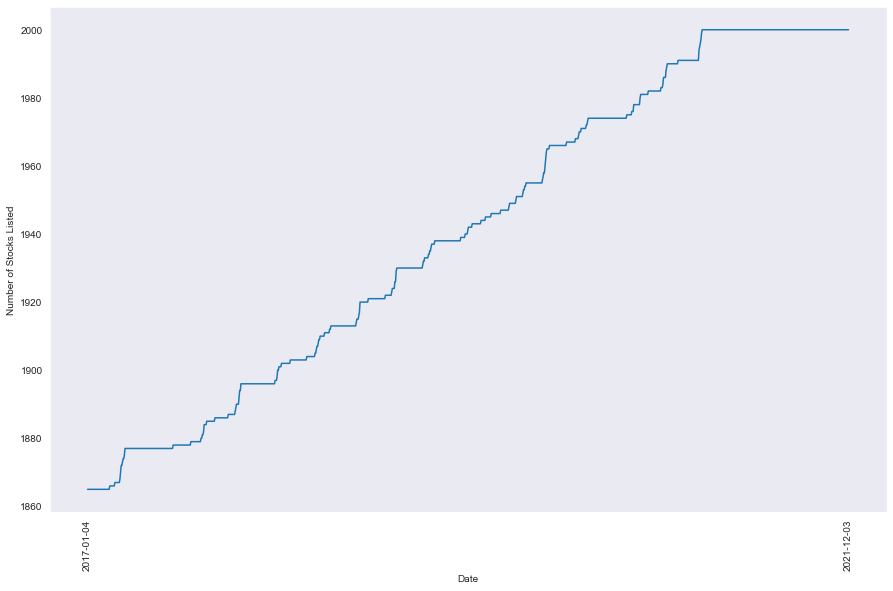

In [6]:
#First lets analyze by date


stocks_day = data.groupby(by=['Date']).size() #computes number of stocks listed on each date
#plot results
ax = sns.lineplot(x = stocks_day.index, y= stocks_day.values)
ax.set_xticklabels([stocks_day.index[0]]+['']*(len(stocks_day)-2)+[stocks_day.index[-1]], rotation=90)
ax.set(ylabel='Number of Stocks Listed')
plt.gcf().set_size_inches(15, 9.3, forward=True) 
plt.show()

In [7]:
full_stocks =stocks_day[stocks_day==2000]
print("Final stock(s) is added on %s and has a total of %d rows. In total there are %d dates listed in the dataset." 
      % (full_stocks.index[0], full_stocks.count(),stocks_day.count(),))

Final stock(s) is added on 2020-12-23 and has a total of 232 rows. In total there are 1202 dates listed in the dataset.


In [8]:
#create a function to calculate the number of days between two dates
def num_days(first, last):
    #Number of days between two dates
    dates = []
    for day in [first, last]:
        dates.append(date(int(day[:4]), int(day[5:7]), int(day[8:])))
    delta = dates[1] - dates[0]
    return delta       

In [9]:
f_date = data['Date'].iloc[0]
l_date = data['Date'].iloc[-1]
print("The first date is %s, the last date is %s, the two dates are %s days apart" % (f_date, l_date, num_days(f_date,l_date).days,))

The first date is 2017-01-04, the last date is 2021-12-03, the two dates are 1794 days apart


There are a different amount of days listed per year.

In [10]:
#new row denoting if date in column is first occurence
#first change date to datetime
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['unique'] = (~data['Date'].duplicated()).astype(int)
print('The total number of days listed by year:')
data[data['unique']==1].groupby(by=['Year']).size()

The total number of days listed by year:


Year
2017    247
2018    245
2019    241
2020    243
2021    226
dtype: int64

In [11]:
data.drop(columns = ['Year','unique'], inplace = True)

### Distribution of days between consecutive dates in dataset
Most dates are either one day apart (consecutive) or are three days apart (weekends).

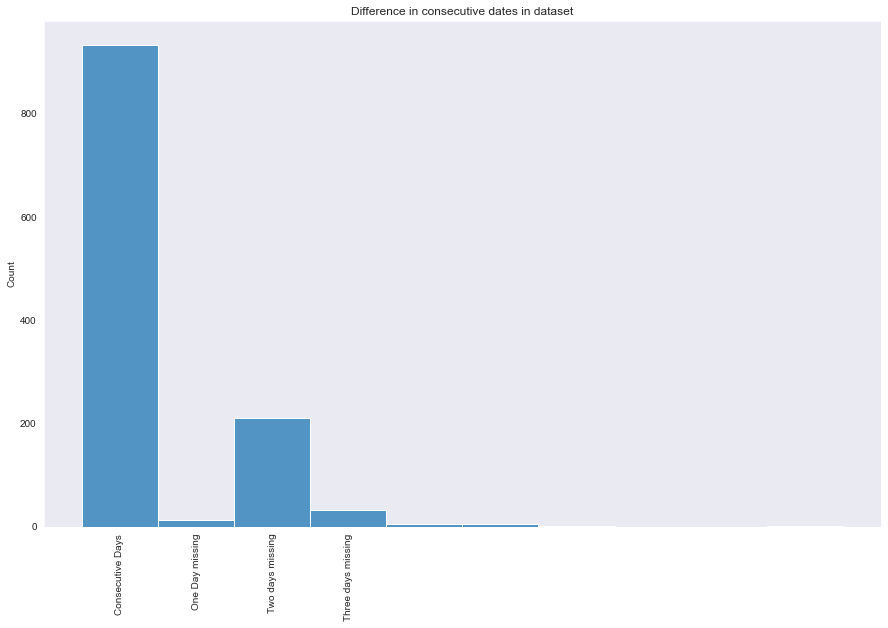

In [12]:
#Number of days between dates
day_diffs = np.diff(data['Date'].unique()).astype('timedelta64[D]').astype('int32')
ax = sns.histplot(x=day_diffs, binwidth=1)
ax.set(title='Difference in consecutive dates in dataset')
ind = np.arange(4)+ 1.5
ax.set_xticks(ind, labels=['Consecutive Days', 'One Day missing', 'Two days missing', 'Three days missing'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.gcf().set_size_inches(15, 9.3, forward=True) 
plt.show()

### Distribution of Open, High, Low, Close, Volume by Stock

In [13]:
means = data.groupby(by=['Code']).mean()[['Open','High', 'Low', 'Close']]

The stock distribution is heavily right skewed.

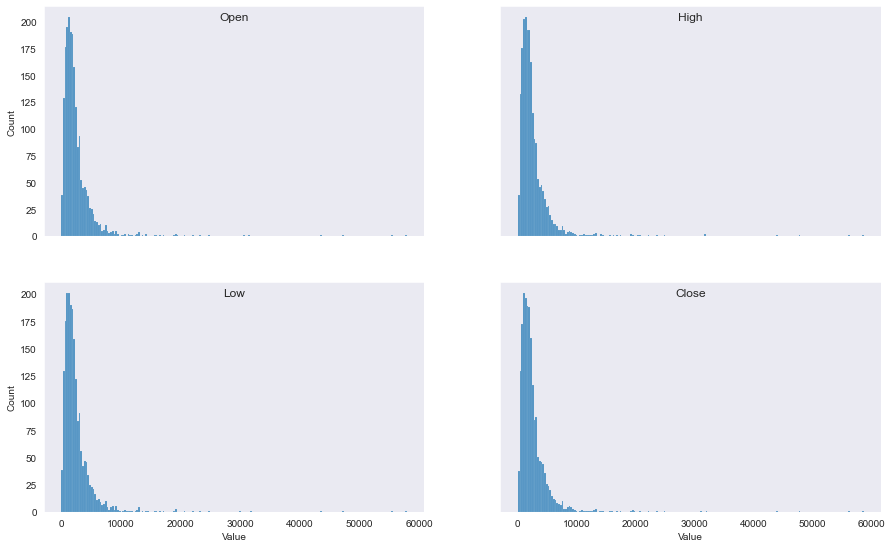

In [14]:
fig, axs = plt.subplots(2, 2)
for ax,col in zip(axs.flat, means.columns):
    sns.histplot(x=means[col], ax=ax)
    ax.set_title(col, y=1.0, pad=-14)
    
for ax in axs.flat:
    ax.set(xlabel='Value', ylabel='Count')
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
plt.gcf().set_size_inches(15, 9.3, forward=True) 
plt.show()

# Missing Values and Imputing

In [15]:
num_na = data.isna().sum()
data_na = pd.DataFrame(num_na, columns = ['Number of Missing Data'])
data_na['% missing'] = num_na/len(data) * 100
data_na

,Number of Missing Data,% missing
RowId,0,0.000000
Date,0,0.000000
Code,0,0.000000
Open,7608,0.326169
High,7608,0.326169
Low,7608,0.326169
Close,7608,0.326169
Volume,0,0.000000
AdjustmentFactor,0,0.000000
ExpectedDividend,2313666,99.191222


Replace ExpectedDividend N/A with 0 and note that all missing values are grouped.

In [16]:
data['ExpectedDividend'] = data['ExpectedDividend'].fillna(0)
#finds all rows with missing values in Open and checks other rows for missing
data[data['Open'].isna()].isna().sum()

RowId                  0
Date                   0
Code                   0
Open                7608
High                7608
Low                 7608
Close               7608
Volume                 0
AdjustmentFactor       0
ExpectedDividend       0
SupervisionFlag        0
Target               238
dtype: int64

### The date 2020-10-01 Has missing values for all entries

In [17]:
#missing data is grouped so just have to check that one column has missing values
missing = data[data['Open'].isna()]
missing['Date'].value_counts()

2020-10-01    1988
2017-03-16      15
2019-10-09      14
2019-04-04      14
2021-10-29      13
              ... 
2017-12-25       1
2017-12-26       1
2020-03-13       1
2018-01-04       1
2018-02-21       1
Name: Date, Length: 1175, dtype: int64

In [18]:
remove_date = missing['Date'].value_counts().index[0]
data.drop(data[data['Date']==remove_date].index, inplace=True)

In [19]:
missing = data[data['Open'].isna()]#stock codes that have atleast one missing value
codes_missing = missing['Code'].value_counts() #number missing values for stocks that have missing values
print("%d stocks have atleast one missing value" % (len(codes_missing),))

122 stocks have atleast one missing value


### For stocks with missing values, what percentage of their values are missing?

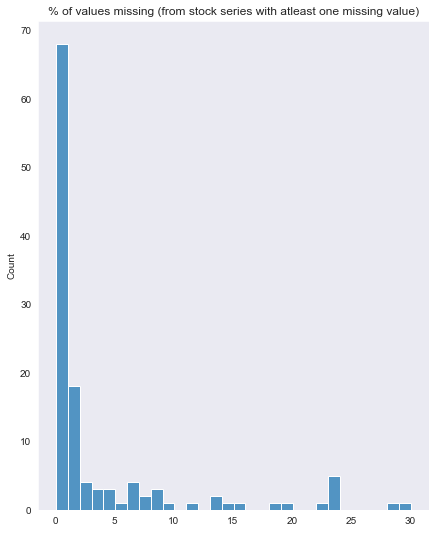

In [20]:
pct_missing = []
for code in codes_missing.index:
    codes_series = data[data['Code']==code]
    pct_missing.append(codes_missing.loc[code]/len(codes_series)*100)
    
pct_missing = pd.Series(data=pct_missing, index=codes_missing.index)
ax = sns.histplot(x=pct_missing, binwidth=1)
ax.set(title='% of values missing (from stock series with atleast one missing value)')
plt.gcf().set_size_inches(7, 9, forward=True) 
plt.show()

### Train/Validation data split
We will need to deal with missing values in train data without any data leakage from holdout data. Note that data will be split into train/validation sequentially, so that data before some date will be used as training data and data after the date will be used for validation.

In [21]:
data['Volume'] = data['Volume'].replace(0, np.float64(np.nan))
holdout_data = data.iloc[-32*2000:].copy()
train_data = data.iloc[:-32*2000]

### First consider the train data

In [22]:
missing = train_data[train_data['Open'].isna()]#stock codes that have atleast one missing value
codes_missing = missing['Code'].value_counts() #number missing values for stocks that have missing values

In [23]:
#two helper functions to analyze data
def fetch_nearest_rows(row, df):
    #returns entries just before and just after for a stock specified by row
    
    #first fetch stock code to create series containing only that stock
    code = row['Code']
    idx = row.name #index of row in df
    code_series = df[df['Code']==code]
    
    #fetch idx of row in series containing only that stock
    indices = code_series.index.to_list()
    idx = indices.index(idx)
    
    #check that row is not last or first value in series
    n = len(code_series)
    
    if idx==0:
        return None, code_series.iloc[idx+1]
    elif idx==n-1:
        return code_series.iloc[idx-1], None
    else:
        return code_series.iloc[idx-1], code_series.iloc[idx+1]    
    
def first_last(missing_df, df):
    #returns two lists
    #first list contains stock codes that have missing value at the start of their code series
    #second list contains stock codes where the missing value is at the end
    first_entries = []
    last_entries = []
    
    codes = missing_df['Code'].unique()
    
    for code in codes:
        code_series = df[df['Code']==code] #Fetch the entire code series for a code from original df
        if code_series.iloc[0].isna().any():
            first_entries.append(code)
        if code_series.iloc[-1].isna().any():
            last_entries.append(code)
            
    return first_entries, last_entries

## Imputing
We want to impute the missing values carefully. We want to be sure that when we are imputing a row we are using data that corresponds to that code. So to impute we will need to consider a "code series" corresponding to all entries containing that stock. To impute we will use linear interpolation and for this we need to 
1. Make sure that there is not a large streak of missing values
2. if there are missing values at the start or end of a code series they will need to be handled differently

In [24]:
#check codes with missing values at start/end of list
first_entries ,last_entries = first_last(missing, train_data)
print(f'Number of stock series with missing first day values:{len(first_entries)}, last day values:{len(last_entries)}')

Number of stock series with missing first day values:24, last day values:8


Looking at codes with missing first entry

In [25]:
first = missing[missing['Code'].isin(first_entries)]
last = missing[missing['Code'].isin(last_entries)]
first_na = first.isna().sum()
last_na = last.isna().sum()
data_na = pd.DataFrame(first_na, columns = ['Missing First'])
data_na['Missing Last'] = last_na
data_na

,Missing First,Missing Last
RowId,0,0
Date,0,0
Code,0,0
Open,412,1511
High,412,1511
Low,412,1511
Close,412,1511
Volume,412,1511
AdjustmentFactor,0,0
ExpectedDividend,0,0


These contain all missing target values. Additionally, they are at the start of code series 2987, 3540, 4056, 4382 with missing Open, High, Low, Close, Volume values. Note that 3540 has a large sequence of missing values at start of df.

In [26]:
train_data[train_data['Code']==3540]

,RowId,Date,Code,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
401,20170104_3540,2017-01-04,3540,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,NaN
2266,20170105_3540,2017-01-05,3540,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,NaN
4131,20170106_3540,2017-01-06,3540,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,NaN
5996,20170110_3540,2017-01-10,3540,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,NaN
7861,20170111_3540,2017-01-11,3540,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2258948,20211012_3540,2021-10-12,3540,6090.0,6200.0,6050.0,6100.0,15700.0,1.0,0.0,True,-0.006557
2260948,20211013_3540,2021-10-13,3540,6100.0,6260.0,5980.0,6100.0,116800.0,1.0,0.0,True,0.003300
2262948,20211014_3540,2021-10-14,3540,6080.0,6080.0,5900.0,6060.0,34500.0,1.0,0.0,True,-0.016447
2264948,20211015_3540,2021-10-15,3540,6060.0,6120.0,5990.0,6080.0,17900.0,1.0,0.0,True,0.008361


In [27]:
#drop beginning of these codes containing missing values
train_data.drop(index=missing[missing['Target'].isna()].index, inplace=True)
missing = train_data[train_data['Open'].isna()]
first_entries ,last_entries = first_last(missing, train_data)
first = missing[missing['Code'].isin(first_entries)]

Let's first inspect codes with first missing values

In [28]:
first['Code'].value_counts()

9539    151
3561      1
4167      1
4165      1
2987      1
4058      1
4056      1
4495      1
4051      1
7351      1
7082      1
4488      1
4482      1
4880      1
4434      1
7047      1
4425      1
4382      1
6572      1
9450      1
3540      1
3990      1
3984      1
4169      1
Name: Code, dtype: int64

### Need to keep in mind that 9539 also has a missing last value
Need to make sure that 9539 doesn't have consecutive missing values at the start of the list. The rest can be safely imputed using the next observation

In [29]:
train_data[train_data['Code']==9539] #first missing value is fine

,RowId,Date,Code,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
1753,20170104_9539,2017-01-04,9539,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,-0.004149
3618,20170105_9539,2017-01-05,9539,482.0,482.0,482.0,482.0,1000.0,1.0,0.0,False,0.000000
5483,20170106_9539,2017-01-06,9539,480.0,480.0,480.0,480.0,1000.0,1.0,0.0,False,0.000000
7348,20170110_9539,2017-01-10,9539,480.0,480.0,480.0,480.0,2000.0,1.0,0.0,False,-0.008333
9213,20170111_9539,2017-01-11,9539,480.0,480.0,480.0,480.0,1000.0,1.0,0.0,False,0.006303
...,...,...,...,...,...,...,...,...,...,...,...,...
2260419,20211012_9539,2021-10-12,9539,3290.0,3290.0,3290.0,3290.0,100.0,1.0,0.0,False,0.000000
2262419,20211013_9539,2021-10-13,9539,3230.0,3295.0,3230.0,3295.0,200.0,1.0,0.0,False,0.000000
2264419,20211014_9539,2021-10-14,9539,3295.0,3295.0,3295.0,3295.0,100.0,1.0,0.0,False,0.000000
2266419,20211015_9539,2021-10-15,9539,NaN,NaN,NaN,NaN,NaN,1.0,0.0,False,0.018209


In [30]:
codes = first['Code'].unique()
for code in codes:
    code_series = train_data[train_data['Code']==code].copy()
    f = code_series.iloc[0]
    f[f.isna()] = code_series.iloc[1][f.isna()]
    code_series.iloc[0] = f

    idxs = code_series.iloc[0].name
    train_data.loc[idxs] = code_series.loc[idxs]

missing = train_data[train_data['Open'].isna()]
last = missing[missing['Code'].isin(last_entries)]
codes = missing['Code'].unique()

For last values missing, to impute we need to ensure the second last value is also not missing.

In [31]:
last['Code'].value_counts()

2761    321
4628    275
1981    270
5918    263
9539    150
9537    141
1793     56
9661     34
Name: Code, dtype: int64

### Streaks of Missing Values
The pandas interpolate method by default will linearly interpolate values and forward fill these last values. What we need to be sure is that there isn't any large streak of missing values where interpolation might not be appropriate.

In [32]:
#groups clumps of missing values
def group_missing(series, df):
    #groups missing values into sections, within each section are adjacent missing values
    #the first and last values in each section are closest non missing values
    missing_groups = []
    for _,v in series[series['Open'].isna()].groupby((~series['Open'].isna()).cumsum()):
        idxs = v.index.to_list()
        
        missing_groups.append(idxs)
        
    return missing_groups
    

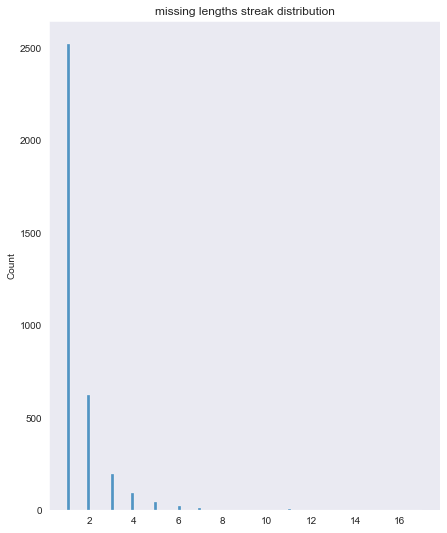

In [33]:
missing_lengths = {}
for code in codes:
    code_series = train_data[train_data['Code']==code]
    missing_groups = group_missing(code_series, train_data)
    
    lengths = []

    for group in missing_groups:
        lengths.append(len(group))
        
    missing_lengths[code] = lengths
    
lengths = [item for sublist in list(missing_lengths.values()) for item in sublist]
lengths.sort(reverse=True)
ax = sns.histplot(x=lengths)
ax.set(title='missing lengths streak distribution')
plt.gcf().set_size_inches(7, 9, forward=True) 
plt.show()

Most missing values are a streak of 1, all are a streak of less than 16. To impute these we will use linear interpolation.

In [34]:
for code in codes:
    code_series = train_data[train_data['Code']==code].copy()
    code_series = code_series.reset_index().set_index('Date')
    code_series = code_series.interpolate(method='time')
    code_series = code_series.reset_index().set_index('index')
    code_series.index.name = None
    
    idxs = missing[missing['Code']==code].index
    
    train_data.loc[idxs] = code_series.loc[idxs]

In [35]:
num_na = train_data.isna().sum()
data_na = pd.DataFrame(num_na, columns = ['Number of Missing Data'])
data_na['% missing'] = num_na/len(train_data) * 100
data_na

,Number of Missing Data,% missing
RowId,0,0.0
Date,0,0.0
Code,0,0.0
Open,0,0.0
High,0,0.0
Low,0,0.0
Close,0,0.0
Volume,0,0.0
AdjustmentFactor,0,0.0
ExpectedDividend,0,0.0


# Imputing Validation Data
We will treat our validation data as new unseen data. In this case, for each row we pretend that we don't possess the information of any rows following it. Thus we will only be able to impute using information from rows before it and cannot use linear interpolation.

In [36]:
holdout_data['ExpectedDividend'] = holdout_data['ExpectedDividend'].fillna(0)
holdout_data['Volume'] = holdout_data['Volume'].replace(0, np.float64(np.nan))
num_na = holdout_data.isna().sum()
holdout_data_na = pd.DataFrame(num_na, columns = ['Number of Missing Data'])
holdout_data_na['% missing'] = num_na/len(holdout_data) * 100
holdout_data_na

,Number of Missing Data,% missing
RowId,0,0.000000
Date,0,0.000000
Code,0,0.000000
Open,203,0.317188
High,203,0.317188
Low,203,0.317188
Close,203,0.317188
Volume,203,0.317188
AdjustmentFactor,0,0.000000
ExpectedDividend,0,0.000000


### Missing Length Streaks

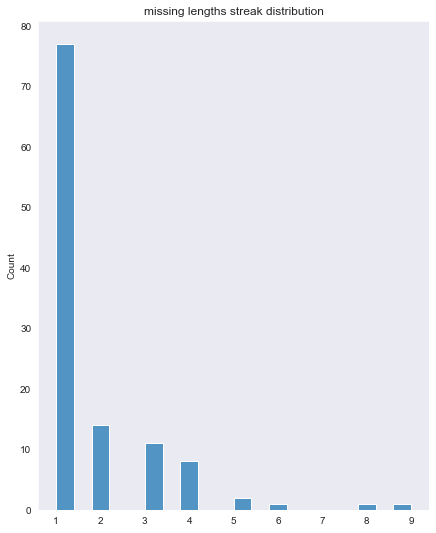

In [37]:
missing = holdout_data[holdout_data['Open'].isna()]

codes_missing = missing['Code'].value_counts()
codes = missing['Code'].unique()

missing_lengths = {}
for code in codes:
    code_series = holdout_data[holdout_data['Code']==code]
    missing_groups = group_missing(code_series, holdout_data)
    
    lengths = []

    for group in missing_groups:
        lengths.append(len(group))
        
    missing_lengths[code] = lengths
    
lengths = [item for sublist in list(missing_lengths.values()) for item in sublist]
lengths.sort(reverse=True)
ax = sns.histplot(x=lengths)
ax.set(title='missing lengths streak distribution')
plt.gcf().set_size_inches(7, 9, forward=True) 
plt.show()

In [38]:
first_entries, last_entries = first_last(missing, holdout_data)
print(f'Some missing values are at the start, number of missing first entries:{len(first_entries)}')

Some missing values are at the start, number of missing first entries:9


In [39]:
#some missing values are at start, append last obs train data to start
temp_holdout = pd.concat([train_data.iloc[-2000:],holdout_data], axis=0)

Here the 'pad' method in pandas, imputes by LOCF (last observation carried forward).

In [40]:
#interpolate test data
for code in codes:
    code_series = temp_holdout[temp_holdout['Code']==code].copy()
    idxs = code_series[code_series['Open'].isna()].index
    code_series = code_series.interpolate(method='pad')
    temp_holdout.loc[idxs] = code_series.loc[idxs]

In [41]:
holdout_data = temp_holdout[2000:].copy()
del temp_holdout

# Saving CSV

In [42]:
data = pd.concat([train_data, holdout_data], axis=0)
data['SupervisionFlag'] = data['SupervisionFlag'].astype(np.int32)
data.to_csv("../../train_files/preprocessed_train.csv", index=False)